<a href="https://www.kaggle.com/code/omershlomo/final-project-nlp?scriptVersionId=133553228" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Title: Quora-insincere-questions-classification**

# **Presentors : Elad Shaked and Omer Shlomo**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is definimport pandas as pd
# For example, here's several helpful packages to load

from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense , Embedding , SimpleRNN
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import json
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re
from sklearn import datasets, svm, metrics
# Download the required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import random
import re
import string
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import transformers as ppb
import warnings
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
!pip install transformers datasets evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.5 MB/s eta 0:00:00


# **Loading The Data**

In [3]:

# This takes a few minutes to run, so go grab a tea or coffee while you wait :)
train = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
test = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')
submission= pd.read_csv('/kaggle/input/quora-insincere-questions-classification/sample_submission.csv')


In [4]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [6]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 1354.73 MB


# **Preproccesing**

In [7]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Remove punctuation
    words = [word for word in words if word not in string.punctuation]
    
    # Join the words back into a single string
    preprocessed_text = ' '.join(words)
    
    return preprocessed_text

In [8]:
train.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [9]:
df=train[:10000]
df['question_text'] = df['question_text'].apply(lambda d : preprocess_text(d))

/tmp/ipykernel_20/863359893.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
cnt_srs = df['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [11]:
import os
import json
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.util import ngrams
from wordcloud import WordCloud

# **N grams**

Train shape: (1306122, 3)
Test shape: (375806, 2)


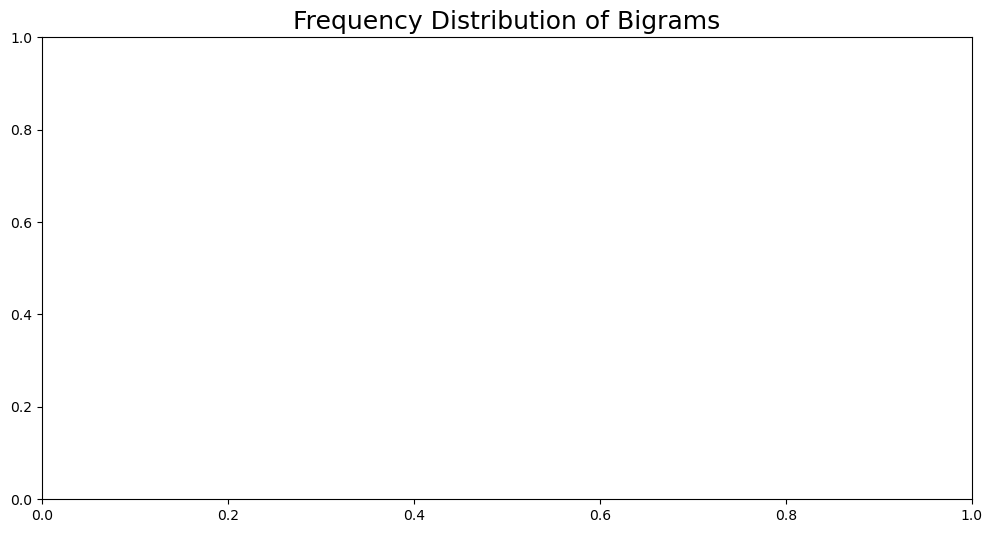

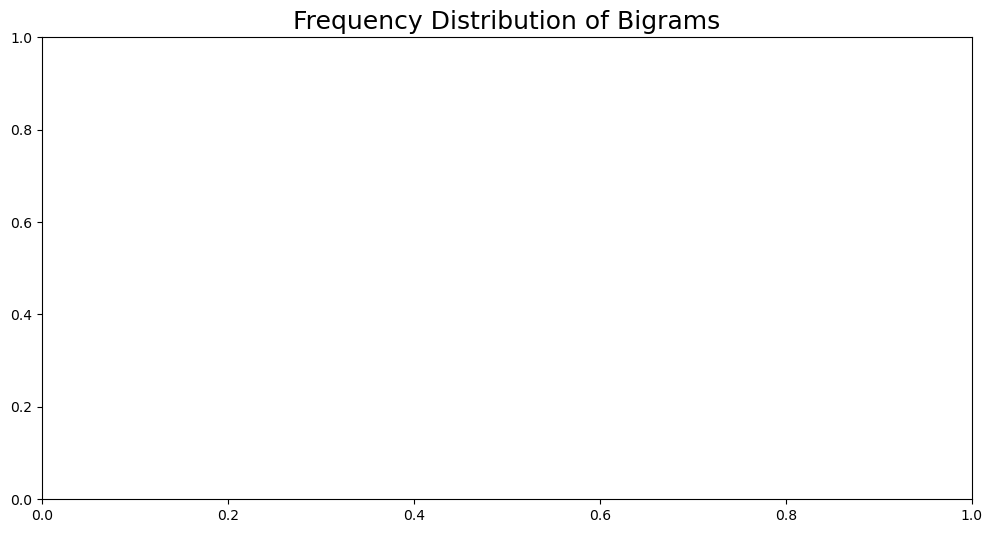

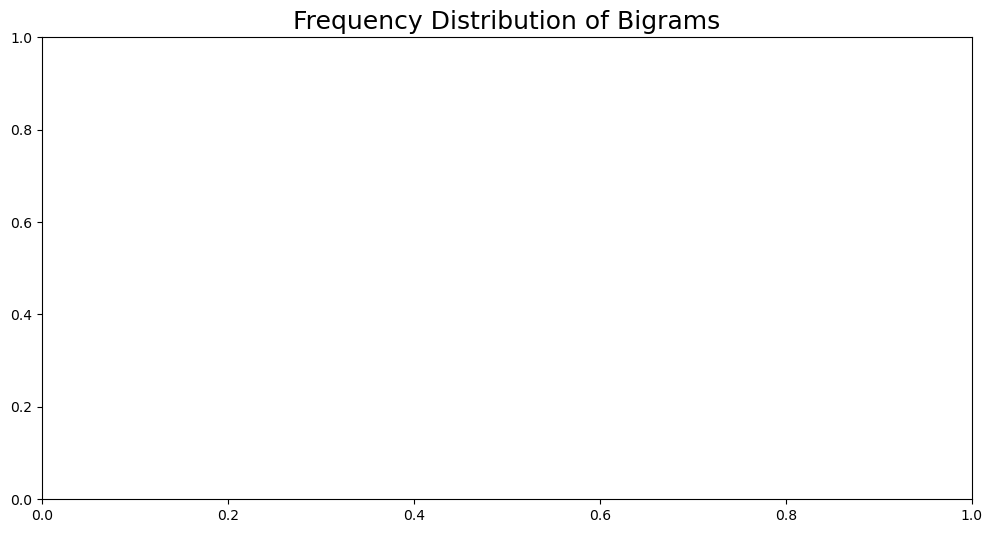

In [12]:


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

stop_words = set(stopwords.words('english'))

print("Train shape:", train.shape)
print("Test shape:", test.shape)


def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

train['cleaned_text'] = train['question_text'].apply(clean_text)


def generate_ngrams(text, n):
    tokens = word_tokenize(text)
    ngrams_list = list(ngrams(tokens, n))
    return [' '.join(gram) for gram in ngrams_list]

def plot_ngrams_freq_dist(text, n, title=None):
    ngrams_list = generate_ngrams(text, n)
    fdist = FreqDist(ngrams_list)
    
    plt.figure(figsize=(12, 6))
#     fdist.plot(30)
    plt.title(title, fontsize=18)
    plt.show()
plot_ngrams_freq_dist(' '.join(train[train['target'] == 1]['cleaned_text']), 3, 'Frequency Distribution of Bigrams')
plot_ngrams_freq_dist(' '.join(train[train['target'] == 1]['cleaned_text']), 2, 'Frequency Distribution of Bigrams')
plot_ngrams_freq_dist(' '.join(train[train['target'] == 1]['cleaned_text']), 1, 'Frequency Distribution of Bigrams')

# **X = text y= target**

In [13]:
X = df['question_text']
y = df['target'][:10000].values

max_words = 10000
tokenizer =  Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [14]:
max_sequence_length = max(len(seq) for seq in sequences )
X = pad_sequences(sequences , maxlen=max_sequence_length )


# **RNN**

In [15]:
x_train , x_test , y_train , y_test =train_test_split(X, y , shuffle=True , test_size=0.2 )


In [16]:
model =  Sequential()
model.add(Embedding(max_words , 32 , input_length= max_sequence_length))
model.add(SimpleRNN(32))
model.add(Dense(1 , activation='sigmoid'))

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
history = model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10
313/313 [==============================] - 5s 11ms/step - loss: 0.2332 - accuracy: 0.9369
Epoch 2/10
313/313 [==============================] - 3s 11ms/step - loss: 0.1198 - accuracy: 0.9580
Epoch 3/10
313/313 [==============================] - 4s 11ms/step - loss: 0.0418 - accuracy: 0.9855
Epoch 4/10
313/313 [==============================] - 3s 11ms/step - loss: 0.0148 - accuracy: 0.9962
Epoch 5/10
313/313 [==============================] - 3s 11ms/step - loss: 0.0071 - accuracy: 0.9983
Epoch 6/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0040 - accuracy: 0.9989
Epoch 7/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0028 - accuracy: 0.9994
Epoch 8/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 9/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 10/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0013 - accura

<Figure size 800x500 with 0 Axes>

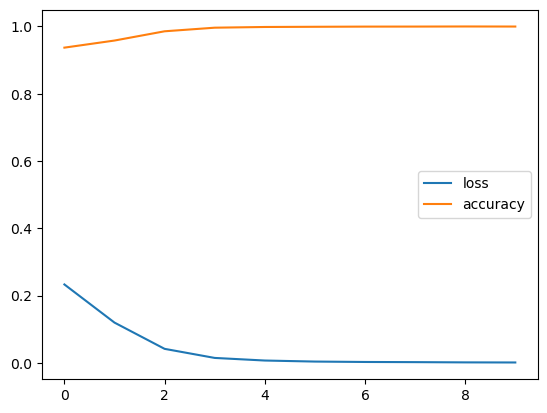

In [19]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [20]:
val_preds= model.predict(x_test)

63/63 [==============================] - 0s 3ms/step


In [21]:
val_preds

array([[1.5767084e-05],
       [2.0673795e-05],
       [4.5136831e-04],
       ...,
       [5.2993378e-06],
       [2.0919043e-04],
       [9.2323648e-04]], dtype=float32)

In [22]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

# **Vocabulary**

In [23]:
from tensorflow.keras.layers import TextVectorization
MAX_FEATURES = 100000

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [24]:
X = df['question_text'][:10000]
y = df['target'][:10000].values

vectorizer.adapt(X.values)

In [25]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 's',
 'get',
 'best',
 'would',
 'people',
 'nt',
 'like',
 'good',
 'india',
 'one',
 'think',
 'many',
 'make',
 'someone',
 'use',
 'time',
 'much',
 'life',
 '’',
 'work',
 'way',
 'ever',
 'want',
 'us',
 'find',
 'without',
 'take',
 'become',
 'know',
 'world',
 'feel',
 'go',
 'year',
 'better',
 'trump',
 'could',
 'person',
 'possible',
 'even',
 'years',
 'quora',
 'mean',
 'indian',
 'need',
 'job',
 'new',
 'old',
 'used',
 'start',
 'women',
 'still',
 'difference',
 'really',
 'first',
 'school',
 'money',
 'm',
 'learn',
 'back',
 'love',
 'ca',
 'getting',
 'online',
 'long',
 'girl',
 'different',
 'country',
 'see',
 'give',
 'business',
 'things',
 'day',
 'sex',
 'made',
 'countries',
 'buy',
 'anyone',
 'thing',
 'english',
 'using',
 'say',
 'stop',
 'men',
 'engineering',
 'two',
 'college',
 'change',
 'university',
 'help',
 'science',
 'real',
 'company',
 'free',
 'live',
 'bad',
 'name',
 'ways',
 'black',
 'happen',
 'computer',
 'white',
 

In [26]:
vectorized_text = vectorizer(X.values)

In [27]:
len(vectorized_text)

10000

# **Logistic regression**

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

train['cleaned_text'] = train['question_text'].apply(clean_text)


# Text vectorization using TF-IDF
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train['cleaned_text'])
y = train['target']

# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions
train_pred = lr.predict(X_train)
val_pred = lr.predict(X_val)

# Evaluation metrics
train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)

print("Training Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

# Show some correct and incorrect predictions
def show_examples(predictions, actual_labels, text_data, num_examples=5):
    correct_indices = np.where(predictions == actual_labels)[0]
    incorrect_indices = np.where(predictions != actual_labels)[0]

    print("Correct Predictions:")
    for idx in np.random.choice(correct_indices, size=num_examples, replace=False):
        print("Question:", text_data.iloc[idx])
        print("Prediction:", predictions[idx])
        print("Actual Label:", actual_labels.iloc[idx])
        print()

    print("Incorrect Predictions:")
    for idx in np.random.choice(incorrect_indices, size=num_examples, replace=False):
        print("Question:", text_data.iloc[idx])
        print("Prediction:", predictions[idx])
        print("Actual Label:", actual_labels.iloc[idx])
        print()

show_examples(val_pred, y_val, train['question_text'])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training Accuracy: 0.952795347292604
Validation Accuracy: 0.9516470475643602
Correct Predictions:
Question: Some Westerners admit they enjoy special treatments and provilage while other Westerners say they face xenophobia and discrimination in Japan, which is more accurate in general?
Prediction: 0
Actual Label: 0

Question: Is PayPal looting bank accounts?
Prediction: 0
Actual Label: 0

Question: What was "the big rumor" in your high school? Did it turn out to be true?
Prediction: 0
Actual Label: 0

Question: What software to use for pixel game?
Prediction: 0
Actual Label: 0

Question: How can I find some topics to write research articles in computer vision?
Prediction: 0
Actual Label: 0

Incorrect Predictions:
Question: How many days should I run Facebook boost?
Prediction: 0
Actual Label: 1

Question: What cream or gel can I use for stubborn black marks on face?
Prediction: 0
Actual Label: 1

Question: What are some of the most feared vehicles in military history?
Prediction: 0
Actu

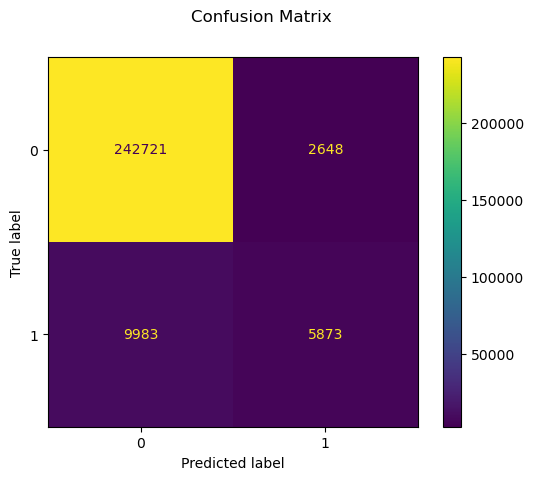

In [29]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_val, val_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

test = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')


def tokenize(text):
  return [stemmer.stem(word) for word in word_tokenize(text) if word.lower() not in english_stopwords]

vectorizer = CountVectorizer(lowercase=True, tokenizer=tokenize, stop_words=english_stopwords, max_features=1000)

vectorizer.fit(df['question_text'])
inputs = vectorizer.transform(df['question_text'])
test_inputs = vectorizer.transform(test['question_text'])


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.



In [31]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, df['target'], test_size=0.3, random_state=42)


model = LogisticRegression(max_iter=1000, solver='sag')
model.fit(train_inputs, train_targets)


train_preds = model.predict(train_inputs)
val_preds= model.predict(val_inputs)


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print(f"Training Accuracy {accuracy_score(train_targets, train_preds)}")
print(f"Training F1 Score {f1_score(train_targets, train_preds)}")

print(f"Validation Accuracy {accuracy_score(val_targets, val_preds)}")
print(f"Validation F1 Score {f1_score(val_targets, val_preds)}")


test_preds = model.predict(test_inputs)

submission_df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/sample_submission.csv")

submission_df['prediction'] = test_preds
submission_df['prediction'].value_counts()

submission_df.to_csv('submission.csv', index=None)
test_pred_csv = pd.read_csv("/kaggle/working/submission.csv")

Training Accuracy 0.9562857142857143
Training F1 Score 0.5248447204968945
Validation Accuracy 0.9423333333333334
Validation F1 Score 0.34716981132075475


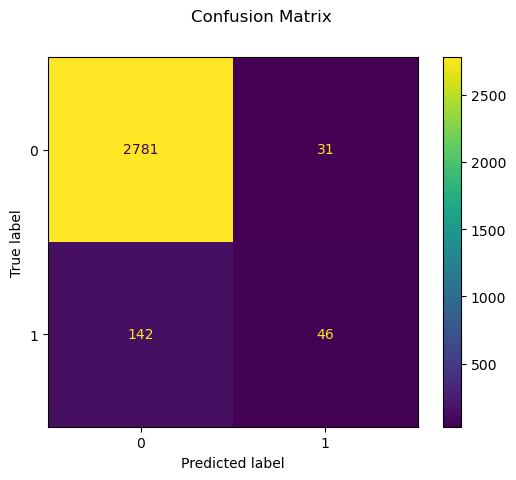

In [32]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(val_targets, val_preds)
disp.figure_.suptitle("Confusion Matrix")

plt.show()